We want to do use our usual thing: Comparing a model with a model on which we know what world-class performance looks like. So here we are once again, working on a curated CS2 data set.

In [1]:
from kan import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import MinMaxScaler

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data and select features
I really should do these in a function next to the dataset.

In [2]:
df = pd.read_csv('~/bayes/data/training-data/dota2_curated.csv.zip', compression='gzip', low_memory=False)
df.source_updated_at = pd.to_datetime(df.source_updated_at, format='ISO8601')

In [3]:
# Parameters to be used in the early game, i.e. before the 10-minute-mark:
features_early = [
 'networth_gap_filtered_20', 
 'xp_gap_filtered_20', 
 'last_hit_gap', 
 'deny_gap', 
 'alive_players_gap_filtered_10', 
 'towers_alive_gap', 
 'first_tower_health_pct_gap',
 #'radiant_pts'  # With no access to the skill rating service, we can not use this feature. Bummer.
]

# Parameters for the later game, i.e. after the 10-minute-mark:
features_late = ['networth_distribution_filtered_20',
 'xp_distribution_filtered_20',
 'kill_gap_filtered_10',
 'building_health_pct_gap',
 'alive_players_gap_filtered_10',  # Normally, we would use a longer filter on a power-transformed feature here, but we don't have that in our curated set and this is just a test.
 'barracks_alive_gap',
 'weakest_lane_towers_remaining_gap',
 'last_tower_health_pct_gap',
 'team_lives_gap_filtered_5']

features = features_early + features_late

In [4]:
df.game_time = df.game_time.astype('float')

In [5]:
# matches start at -90 seconds, but our data sometimes starts later. mark the real "first" rows so we can use them later
df = df.assign(true_first=df.game_time==-90)

In [6]:
max_gt = df.groupby('map_id').game_time.max()

In [7]:
df = df.merge(max_gt, left_on='map_id', right_index=True, suffixes=['', '_max'])

In [8]:
before = df.map_id.nunique()
df = df[df.game_time_max > 600].copy()
print(f'Removed {before - df.map_id.nunique()} matches because they were too short')

Removed 180 matches because they were too short


In [9]:
to_remove = []
for c in ['deny_gap', 'kill_gap_filtered_10', 'last_hit_gap']:
    to_remove.extend(list((df[(df.true_first) &(df[c] != 0)].map_id.unique())))
if len(to_remove) > 0:
    df = df[~df.map_id.isin(to_remove)].copy()
    print(f'Removed {len(to_remove)} matches because they started with strange values')

In [10]:
# remove the last row of each (finished) match, because it contains doctored data
df = df[df.game_time != df.game_time_max].copy()

In [11]:
for c in [i for i in features if 'tanh' in i]:
    df[c] = df[c[:-5]].div(df[c[:-5]].quantile(.9)).apply(lambda x: np.tanh(x))
    pars[c+'_scaling'] = df[c[:-5]].quantile(.9)

In [12]:
# train/test split without balancing - balancing happens in the traning function
def print_summary(df, name):
    print(f'{name} data has {df.map_id.nunique()} matches with mean winner matchwise {df.groupby("map_id").last().map_winner.mean():.2f} / rowwise {df.map_winner.mean():.2f}.  Dire wins: {len(df[df.map_winner==1])} rows. Radiant wins: {len(df[df.map_winner==0])} rows. {df[df.game_time_max>50].map_id.nunique()} matches are over 50 minutes long. Oldest match is from {df.source_updated_at.min().date()}. Newest match is from {df.source_updated_at.max().date()}.\n')
    
df.sort_values(by='source_updated_at', inplace=True)
matches = df.map_id.unique()
train_matches = matches[:int(0.8*len(matches))]
test_matches = [i for i in matches if i not in train_matches]
for selection, name in zip([train_matches, test_matches], ['Training', 'Test']):
    print_summary(df[df.map_id.isin(selection)], name)

Training data has 1028 matches with mean winner matchwise 0.52 / rowwise 0.53.  Dire wins: 146254 rows. Radiant wins: 130723 rows. 1028 matches are over 50 minutes long. Oldest match is from 2024-12-27. Newest match is from 2025-05-27.

Test data has 257 matches with mean winner matchwise 0.54 / rowwise 0.55.  Dire wins: 38974 rows. Radiant wins: 32439 rows. 257 matches are over 50 minutes long. Oldest match is from 2025-05-27. Newest match is from 2025-06-24.



In [13]:
df_train = df.query('map_id in @train_matches')
df_test = df.query('map_id in @test_matches')

# Train a KAN

In [14]:
# Create separate matrices for the KAN, as the KAN wants torch-style arrays. Also normalise it, while we are at it.
df_kan_train_early = df_train[df_train.game_time <= 600][features_early + ['map_winner']].sample(frac=1.0)
df_kan_test_early = df_test[df_test.game_time <= 600][features_early + ['map_winner']].sample(frac=1.0)

df_kan_train_late = df_train[df_train.game_time <= 600][features_late + ['map_winner']].sample(frac=1.0)
df_kan_test_late = df_test[df_test.game_time <= 600][features_late + ['map_winner']].sample(frac=1.0)

scaler = MinMaxScaler()

# Create labels needed for framing as classification problem with one-hot encoded targets, since the regression formulation failed:
train_labels_early = torch.zeros(len(df_kan_train_early), 2)
train_labels_late = torch.zeros(len(df_kan_train_late), 2)
test_labels_early = torch.zeros(len(df_kan_test_early), 2)
test_labels_late = torch.zeros(len(df_kan_test_late), 2)

for k, label in enumerate(df_kan_train_early.map_winner):
    train_labels_early[k, label] = 1

for k, label in enumerate(df_kan_train_late.map_winner):
    train_labels_late[k, label] = 1

for k, label in enumerate(df_kan_test_early.map_winner):
    test_labels_early[k, label] = 1

for k, label in enumerate(df_kan_test_late.map_winner):
    test_labels_late[k, label] = 1

dataset_early = {
    'train_input': torch.from_numpy(scaler.fit_transform(df_kan_train_early[features_early])),
    'test_input': torch.from_numpy(scaler.fit_transform(df_kan_test_early[features_early])),
    'train_label': train_labels_early,
    'test_label': test_labels_early,
}

dataset_late = {
    'train_input': torch.from_numpy(scaler.fit_transform(df_kan_train_late[features_late])),
    'test_input': torch.from_numpy(scaler.fit_transform(df_kan_test_late[features_late])),
    'train_label': train_labels_late,
    'test_label': test_labels_late,
}

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.02e-01 | test_loss: 9.41e-01 | reg: 6.85e+00 | : 100%|█| 500/500 [01:01<00:00,  8.15


saving model version 0.1


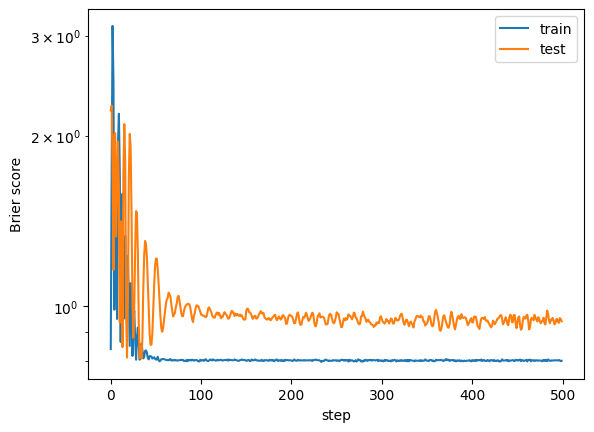

In [15]:
grids = [5]

train_losses = []
test_losses = []

# Use the Brier score as custom loss function:
def custom_loss(y_pred, y_true):
    return torch.mean(
        (y_pred - torch.argmax(y_pred))**2
    )

for i, grid_size in enumerate(grids):
    if i == 0:
        kan_mdl = KAN(width=[len(features_early), 2], grid=grid_size, k=5, seed=983457, device=device)
    else:
        kan_mdl = kan_mdl.refine(grid_size)
    res = kan_mdl.fit(dataset_early, opt="Adam", batch=10_000, steps=500, lamb=0.001, loss_fn=torch.nn.CrossEntropyLoss());
    train_losses += res['train_loss']
    test_losses += res['test_loss']

plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('Brier score')
plt.xlabel('step')
plt.yscale('log')

In [16]:
len(dataset_early['test_label'])

19361

In [17]:
(torch.argmax(kan_mdl(dataset_early['test_input']), dim=1) == 1).sum()

tensor(19007)

In [18]:
torch.argmax(dataset_early['test_label'], dim=1)

tensor([0, 1, 1,  ..., 1, 1, 1])

In [19]:
kan_mdl(dataset_early['test_input'])

tensor([[-1.0846,  0.3339],
        [-1.1915,  0.5858],
        [-1.1434,  0.5211],
        ...,
        [-1.8724,  1.3076],
        [-1.1552,  0.5221],
        [-1.1045,  0.4758]], grad_fn=<AddBackward0>)

In [20]:
dataset_early['test_label']

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])

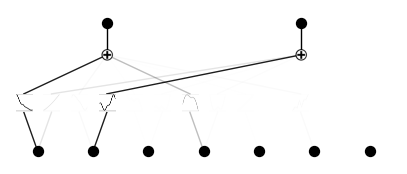

In [21]:
kan_mdl.plot()

In [22]:
# How often do they predict a Dire win?
torch.mean((torch.argmax(kan_mdl(dataset_early['test_input']), dim=1) == 1).to(float))

tensor(0.9817)

In [23]:
# How often should they have predicted a Dire win?
torch.mean((torch.argmax(dataset_early['test_label'], dim=1) == 1).to(float))

tensor(0.5384)

Any version of the classifier tried fails soundly, just like with the CS2 case. Despite the most important features being expressive with correlations around 0.35'ish, the training loss stays at exactly 0.5.

When looking at the predicted values, you can see that in general, class 1 = Dire win is nearly always the predicted outcome. There is something fishy in the state of Denmark.

A simple MLP trained in parallel does the job withtout problems and ofc Catboost does it as well. There seems to be something off with the optimisation when low-expressive features are in the mix. But that is just a hunch.